In [1]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.utils import train_fn
from astra.torch.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
path = "/home/vannsh.jani/brick_kilns/ssl_exp/data"
x_train = torch.load(join(path, "ban_x_train.pt"))
y_train = torch.load(join(path, "ban_y_train.pt"))
x_test = torch.load(join(path, "ban_x_test.pt"))
y_test = torch.load(join(path, "ban_y_test.pt"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_b = torch.cat([x_train, x_test], dim=0).to(device)
y_b = torch.cat([y_train, y_test], dim=0).to(device)

print(x_b.shape, y_b.shape)

torch.Size([19124, 3, 224, 224]) torch.Size([19124]) torch.Size([6375, 3, 224, 224]) torch.Size([6375])
torch.Size([25499, 3, 224, 224]) torch.Size([25499])


In [3]:
x_d = torch.load(join(path, "delhi_test_images_50.pt")).to(device)
y_d = torch.load(join(path, "delhi_test_labels_50.pt")).to(device)
print(x_d.shape, y_d.shape)

torch.Size([5013, 3, 224, 224]) torch.Size([5013])


In [4]:
# Downstream model
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        eff = torchvision.models.efficientnet_b0(weights=None)
        self.eff = nn.Sequential(*list(eff.children())[:-1])
        self.last_layer = list(eff.children())[-1]
        self.eff.load_state_dict(torch.load("/home/vannsh.jani/brick_kilns/ssl_exp/byol/byol_bd_150.pth")) # load different weights
        self.last_layer[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.eff(x).squeeze(-2, -1)
        # print(x.shape)
        x = self.last_layer(x)
        return x

In [5]:
model = DownstreamModel(2).to(device)
model(torch.rand(2, 3, 224, 224).to(device)).shape

torch.Size([2, 2])

In [6]:
lr = 1e-4
epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(epochs):
    print("Epoch:", epoch)
    model.train()
    iter_losses, epoch_losses = train_fn(model, loss_fn, x_b, y_b, lr=lr, epochs=1, batch_size=64)
    
    model.eval()
    
    with torch.no_grad():
        local_losses = []
        for i in range(0, len(x_b), 64):
            y_pred = model(x_b[i:i+64])
            loss = loss_fn(y_pred, y_b[i:i+64].long())
            local_losses.append(loss.item())

        train_losses.append(sum(local_losses)/len(local_losses))
    
    with torch.no_grad():
        y_pred = model(x_d)
        test_loss = loss_fn(y_pred, y_d.long())
        test_losses.append(test_loss.item())
        y_pred = torch.argmax(y_pred, dim=1)
        print("Accuracy:", accuracy_score(y_d, y_pred))
        print("Precision:", precision_score(y_d, y_pred))
        print("Recall:", recall_score(y_d, y_pred))
        print("F1 Score:", f1_score(y_d, y_pred))
        print("Train Loss:", train_losses[-1])
        print("Test Loss:", test_losses[-1])
        
    torch.cuda.empty_cache()

Epoch: 0


Loss: 0.10794935: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9386, device='cuda:0')
Precision: tensor(0.7658, device='cuda:0')
Recall: tensor(0.6821, device='cuda:0')
F1 Score: tensor(0.7215, device='cuda:0')
Train Loss: 0.029236862726537582
Test Loss: 0.15971051156520844
Epoch: 1


Loss: 0.03188365: 100%|██████████| 1/1 [00:24<00:00, 24.50s/it]


Accuracy: tensor(0.9396, device='cuda:0')
Precision: tensor(0.7697, device='cuda:0')
Recall: tensor(0.6866, device='cuda:0')
F1 Score: tensor(0.7258, device='cuda:0')
Train Loss: 0.014292655493725642
Test Loss: 0.15863411128520966
Epoch: 2


Loss: 0.01603327: 100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


Accuracy: tensor(0.9507, device='cuda:0')
Precision: tensor(0.7159, device='cuda:0')
Recall: tensor(0.7903, device='cuda:0')
F1 Score: tensor(0.7513, device='cuda:0')
Train Loss: 0.006669526534187981
Test Loss: 0.17830879986286163
Epoch: 3


Loss: 0.00742396: 100%|██████████| 1/1 [00:24<00:00, 24.48s/it]


Accuracy: tensor(0.9443, device='cuda:0')
Precision: tensor(0.7735, device='cuda:0')
Recall: tensor(0.7145, device='cuda:0')
F1 Score: tensor(0.7429, device='cuda:0')
Train Loss: 0.004447783853841277
Test Loss: 0.1741524189710617
Epoch: 4


Loss: 0.00521822: 100%|██████████| 1/1 [00:24<00:00, 24.45s/it]


Accuracy: tensor(0.9497, device='cuda:0')
Precision: tensor(0.7121, device='cuda:0')
Recall: tensor(0.7844, device='cuda:0')
F1 Score: tensor(0.7465, device='cuda:0')
Train Loss: 0.00260073177984547
Test Loss: 0.2596641182899475
Epoch: 5


Loss: 0.00421059: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9575, device='cuda:0')
Precision: tensor(0.7025, device='cuda:0')
Recall: tensor(0.8632, device='cuda:0')
F1 Score: tensor(0.7746, device='cuda:0')
Train Loss: 0.0018026208921557946
Test Loss: 0.2526005506515503
Epoch: 6


Loss: 0.00399930: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9529, device='cuda:0')
Precision: tensor(0.6526, device='cuda:0')
Recall: tensor(0.8608, device='cuda:0')
F1 Score: tensor(0.7424, device='cuda:0')
Train Loss: 0.0035432395113935457
Test Loss: 0.3058106303215027
Epoch: 7


Loss: 0.00342010: 100%|██████████| 1/1 [00:24<00:00, 24.47s/it]


Accuracy: tensor(0.9422, device='cuda:0')
Precision: tensor(0.6430, device='cuda:0')
Recall: tensor(0.7631, device='cuda:0')
F1 Score: tensor(0.6979, device='cuda:0')
Train Loss: 0.0029214904425467502
Test Loss: 0.3704482614994049
Epoch: 8


Loss: 0.00329036: 100%|██████████| 1/1 [00:24<00:00, 24.48s/it]


Accuracy: tensor(0.9471, device='cuda:0')
Precision: tensor(0.7582, device='cuda:0')
Recall: tensor(0.7397, device='cuda:0')
F1 Score: tensor(0.7488, device='cuda:0')
Train Loss: 0.0053722863799829015
Test Loss: 0.3078685998916626
Epoch: 9


Loss: 0.00363864: 100%|██████████| 1/1 [00:24<00:00, 24.48s/it]


Accuracy: tensor(0.9517, device='cuda:0')
Precision: tensor(0.7754, device='cuda:0')
Recall: tensor(0.7637, device='cuda:0')
F1 Score: tensor(0.7695, device='cuda:0')
Train Loss: 0.0020416102393444263
Test Loss: 0.27428677678108215


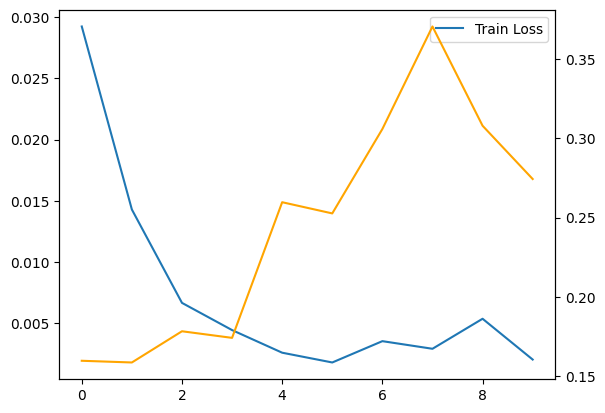

In [7]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.gca().twinx().plot(test_losses, label="Test Loss", color="orange")
# torch.save(model.state_dict(), "byol_lr4_ep50.pth")

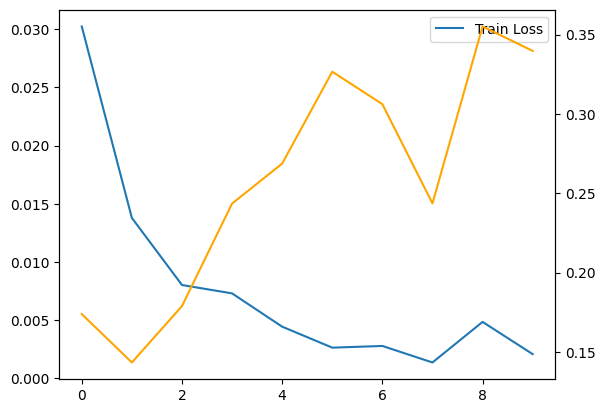